In [1]:
#from src import*
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.svm import OneClassSVM
from numpy import quantile, where, random
from sklearn.manifold import TSNE
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score, recall_score
from sklearn.metrics import roc_auc_score
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from src import PREPROCESSING, Model_Selection
PP = PREPROCESSING('Task1_1.csv', 'Task1_2.csv')
df_independent_feature, df_label = PP.process(threshold= 0.8 )

MS = Model_Selection(df_independent_feature, df_label)
MS.process()

In [2]:
class PREPROCESSING:
    
    def __init__(self, task1_data_path, task2_data_path):
        """
        
        This class give information about the datasets.
        
        """
        self.df_task1 = pd.read_csv(task1_data_path, sep=';')
        self.df_task2 = pd.read_csv(task2_data_path, sep=';')
    
    def handle_duplicates_complete(self):
        """
        This method handles the duplicates in the datasets
        
        """
        self.df_task1 = self.df_task1.drop_duplicates()
        self.df_task2 = self.df_task2.drop_duplicates()
    
    def handle_duplicates_ID(self):
        """
        This method handles the duplicates in 'ID' before 
        joing the dataset
        
        """
        
        self.df_task1 = self.df_task1.drop_duplicates("ID")
        self.df_task2 = self.df_task2.drop_duplicates("ID")
        
    def merge_data(self):
        
        """
        Merge the datasets on 'ID'
        
        """
        self.df_merged = pd.merge(self.df_task1,self.df_task2,on='ID')
        self.df_original =self.df_merged.copy()
        
    def handle_missing_values(self):
        """
        Remove the column 'ZIK' with majority values missing
        
        """
        del self.df_merged['ZIK']
        
        
    def impute_missing_values(self):
        """
        
        Impute the missing values in the numerical columns with mean and 
        categorical column with mode
        
        """
        self.num_vars = self.df_merged.select_dtypes(include='number').columns.tolist()
        num_imputer = SimpleImputer(strategy='mean')
        self.df_merged[self.num_vars] = num_imputer.fit_transform(self.df_merged[self.num_vars])
        self.cat_vars = self.df_merged.select_dtypes(include='object').columns.tolist()
        cat_imputer = SimpleImputer(strategy='most_frequent')
        self.df_merged[self.cat_vars] = cat_imputer.fit_transform(self.df_merged[self.cat_vars])
        
    def handle_imbalance(self, oversampling_ratio):
        """
        Handle the imbalance in the target by oversampling
        """
        self.minority_class = self.df_merged[self.df_merged['Type'] == 'n']
        self.majority_class = self.df_merged[self.df_merged['Type'] == 'y']
        self.df_balanced = pd.concat([self.majority_class] + [self.minority_class]*int(oversampling_ratio))

    def one_hot_encode(self):
        """
        One hot encode the categorical features 
        Retain the target variable unchanged
        
        """
        
        self.df_one_hot_encoded = pd.get_dummies(self.df_balanced, columns=self.cat_vars[:-1])*1
        self.df_before_transform = self.df_one_hot_encoded.copy()
    def scale_numerical_features(self):
        """
        Scale the numerical variables 
        
        """
        self.df_num = self.df_one_hot_encoded[self.num_vars[1:]]
        scaler = MinMaxScaler()
        self.scaled_data = scaler.fit_transform(self.df_num)
        self.df_one_hot_encoded[self.num_vars[1:]] = pd.DataFrame(self.scaled_data, columns=self.num_vars[1:])
        #self.df_before_transform = self.df_one_hot_encoded.copy()
    def log_transform(self,log_list):
        """
        log transform done to remove skewness
        
        """
        for col in log_list:
             self.df_one_hot_encoded[col] = np.log(self.df_one_hot_encoded[col])
        self.df_one_hot_encoded = self.df_one_hot_encoded.replace([np.inf, -np.inf],0)
    def remove_correlated(self, threshold):
        """
        Consider columns other than 'ID' and 'Type'
        Remove the correlated feature using a threshold 
        
        """
        
        self.df_dropped = self.df_one_hot_encoded.drop(['ID', 'Type'], axis=1)
        self.df_corr = self.df_dropped.corr(method='pearson', min_periods=1)
        self.df_not_correlated = ~(self.df_corr.mask(np.tril(np.ones([len(self.df_corr)]*2, dtype=bool))).abs() > threshold).any()
        self.un_corr_idx = self.df_not_correlated.loc[self.df_not_correlated[self.df_not_correlated.index] == True].index
        self.df_uncorr = self.df_dropped[self.un_corr_idx]
        self.df_uncorr['ID']=self.df_one_hot_encoded['ID']
        self.df_uncorr['Type']=self.df_one_hot_encoded['Type']
        
    def drop_feature_importance(self , feature_imp_threshold):
        """
        Drop the feature with less importance
        
        """
        
        self.X = self.df_uncorr[self.df_uncorr.columns[:-2]]
        self.y = self.df_uncorr[['Type']]
        clf = ExtraTreesClassifier(n_estimators=50)
        clf = clf.fit(self.X, self.y)
        self.feature_imp = clf.feature_importances_  
        self.model = SelectFromModel(clf, prefit=True, threshold= feature_imp_threshold)
        self.X_new = self.model.transform(self.X)
        
    def optimal_feature(self): 
        """
        Retain the features with importance
        """
        self.selected_feature_indices = self.model.get_support()
        self.selected_feature_names = self.df_uncorr.columns[:-2][self.selected_feature_indices]
        self.df_independent_feature = pd.DataFrame(data=self.X_new, columns=self.selected_feature_names)
                       
    def target_map(self):
        """
        Map the target column 'Type' from ['n', 'y'] to ['0', '1']
        """
        self.y['Type'] = self.y.Type.replace(to_replace=['n', 'y'], value=[0, 1])
        self.df_label = self.y
        
    def process(self, oversampling_ratio = 1, log_list=['CDx','POUG','TRE'], threshold = 0.2, feature_imp_threshold = 5e-3):
        """
        Process all the methods inside the class
        """
        self.handle_duplicates_complete()
        self.handle_duplicates_ID()
        self.merge_data()
        self.impute_missing_values()
        self.handle_imbalance(oversampling_ratio)
        self.one_hot_encode()
        self.log_transform(log_list)
        self.scale_numerical_features()
        self.remove_correlated(threshold)
        self.drop_feature_importance( feature_imp_threshold)
        self.optimal_feature()
        self.target_map()
        return self.df_independent_feature, self.df_label

In [3]:
PP = PREPROCESSING('Task1_1.csv', 'Task1_2.csv')
df_independent_feature, df_label = PP.process(threshold= 0.8 )


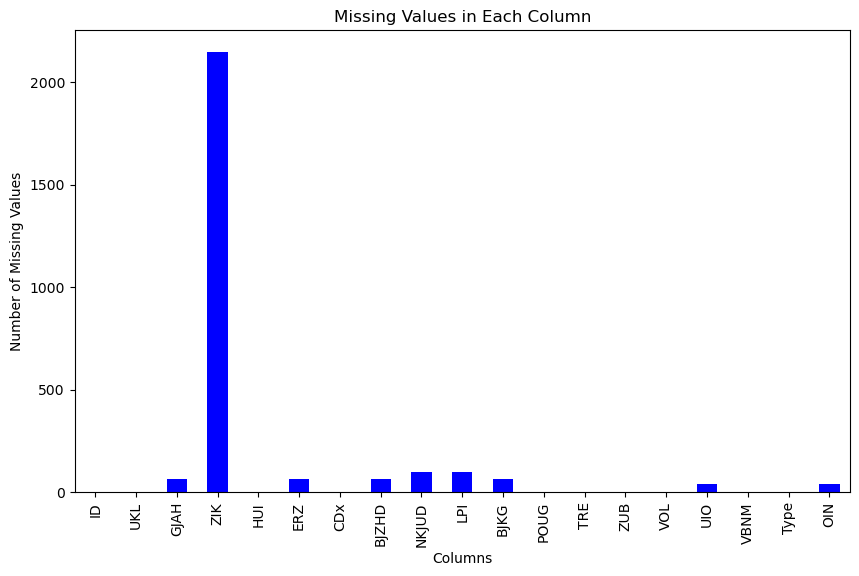

In [4]:
missing_values = PP.df_original.isnull().sum()
plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar', color='blue')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in Each Column')
plt.show()

In [5]:
count_by_type = PP.df_merged.groupby(['Type']).size()
count_by_type

Type
n     276
y    3424
dtype: int64

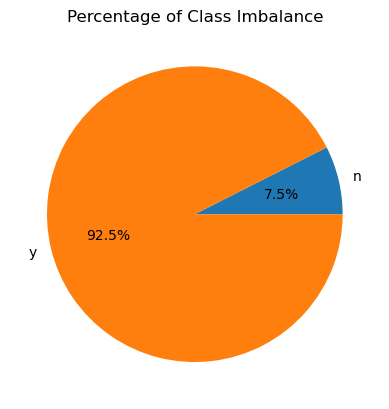

In [6]:
count_by_type.plot(kind='pie', autopct='%1.1f%%')
plt.title('Percentage of Class Imbalance')
plt.show()


size is not changing because oversampling ratio is 1

In [7]:
print(PP.df_balanced.groupby(['Type']).size()) 

Type
n     276
y    3424
dtype: int64


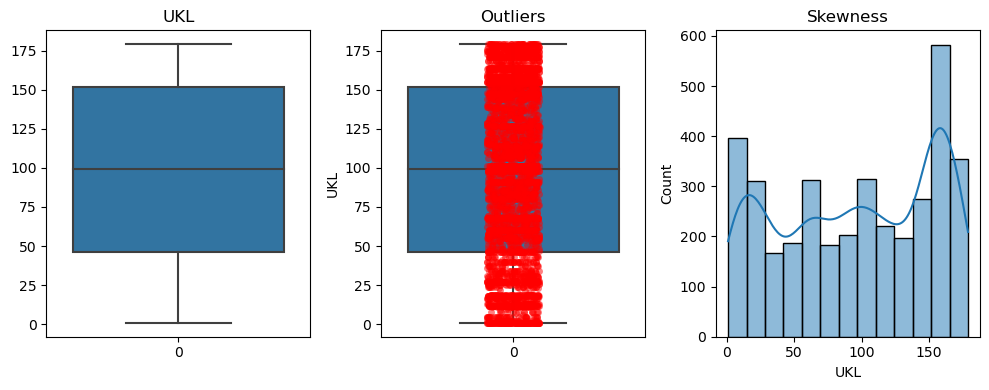

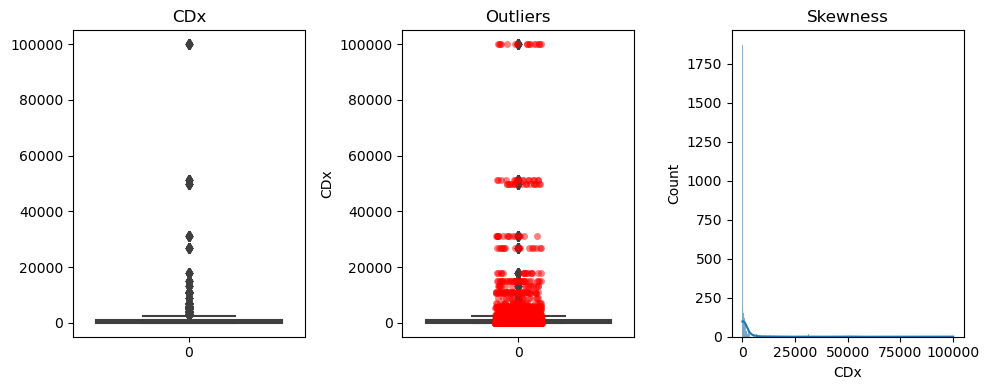

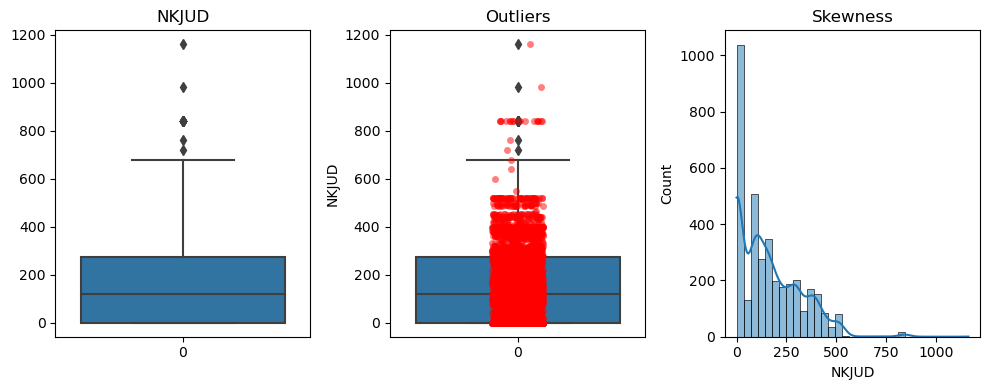

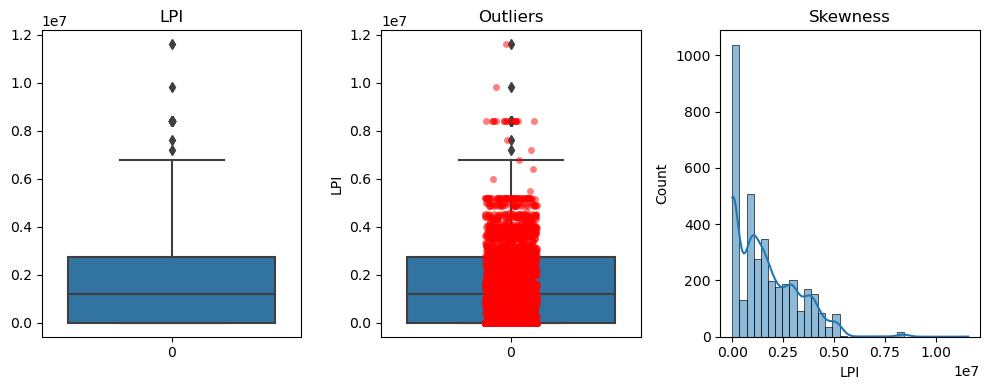

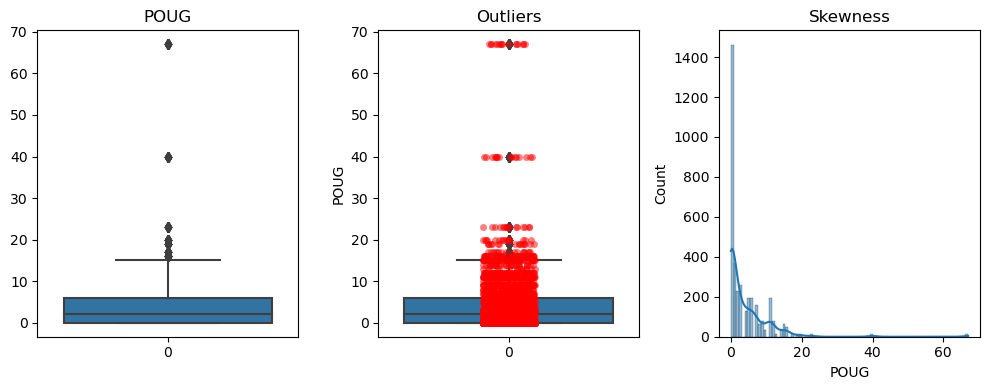

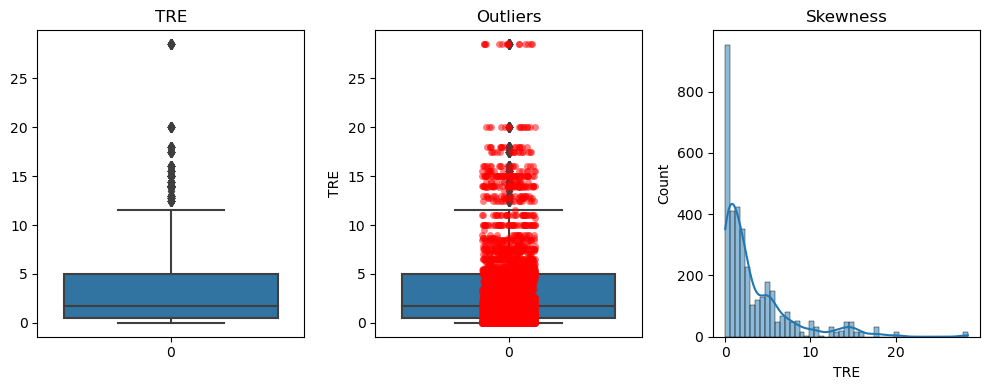

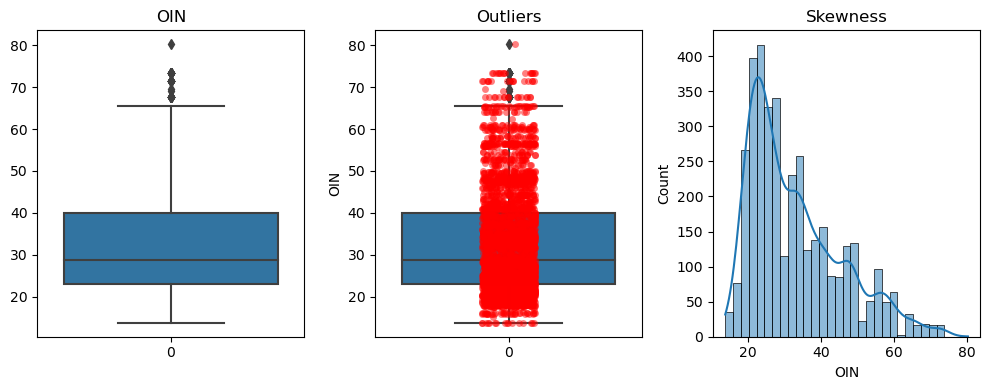

In [8]:
for column in PP.num_vars[1:]:
        plt.figure(figsize=(10, 4))
        
        # Plotting the column values
        plt.subplot(1, 3, 1)
        sns.boxplot(PP.df_merged[column])
        plt.title(column)
        
        # Plotting the outliers
        plt.subplot(1, 3, 2)
        sns.boxplot(PP.df_merged[column])
        sns.stripplot(PP.df_merged[column], color='red', marker='o', alpha=0.5)
        plt.title("Outliers")
        
        # Plotting the skewness
        plt.subplot(1, 3, 3)
        sns.histplot(PP.df_merged[column], kde=True)
        plt.title("Skewness")
        plt.xlabel(column)
        
        plt.tight_layout()
        plt.show()

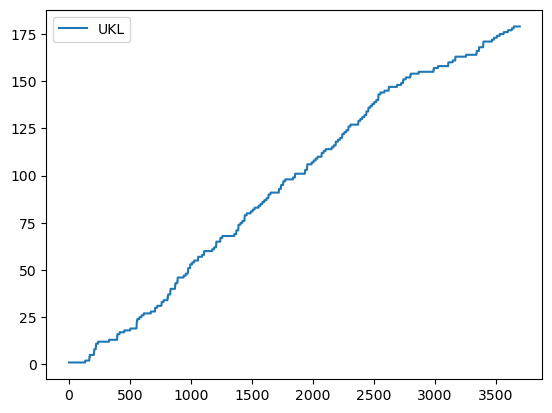

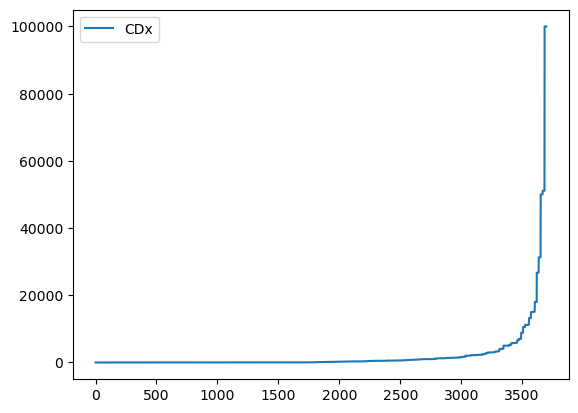

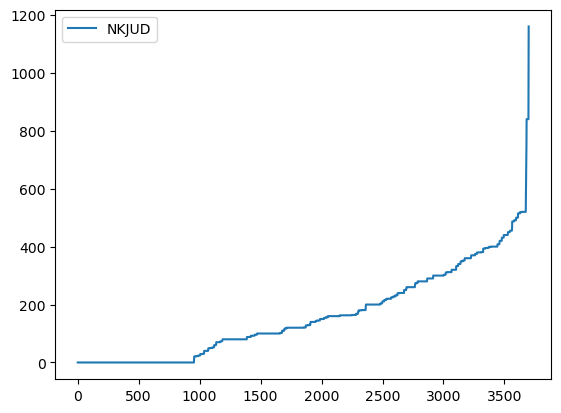

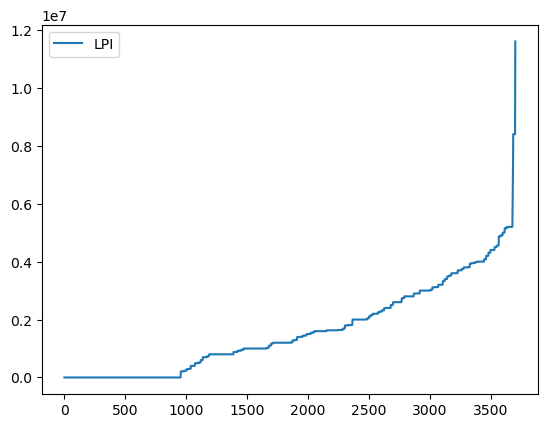

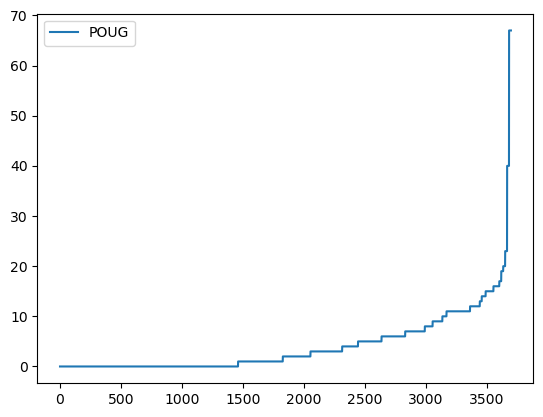

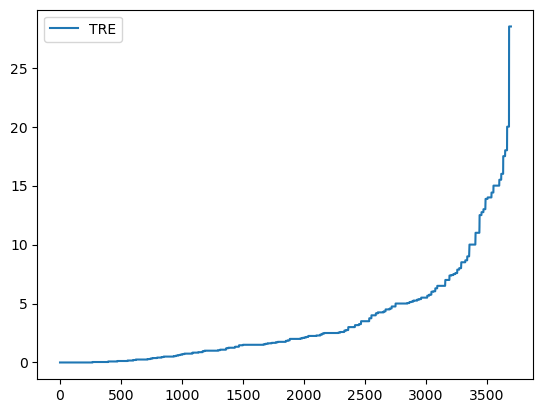

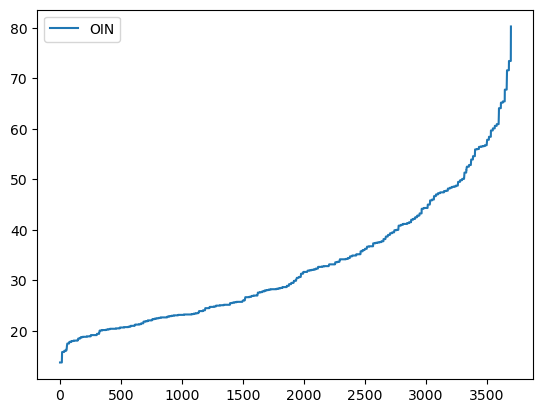

In [9]:
PP.df_before_transform
for i in PP.num_vars[1:]:
    df=PP.df_before_transform[i].sort_values()
    df = df.reset_index()
    del df['index']
    df.plot()

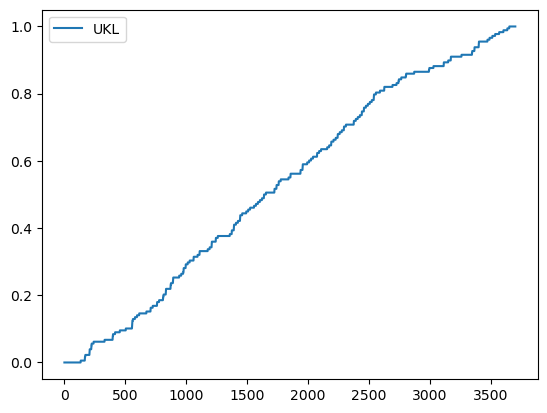

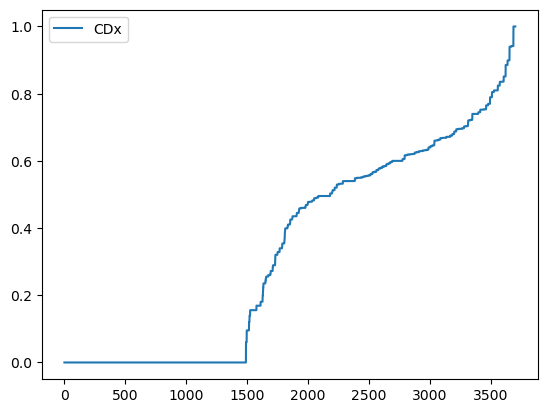

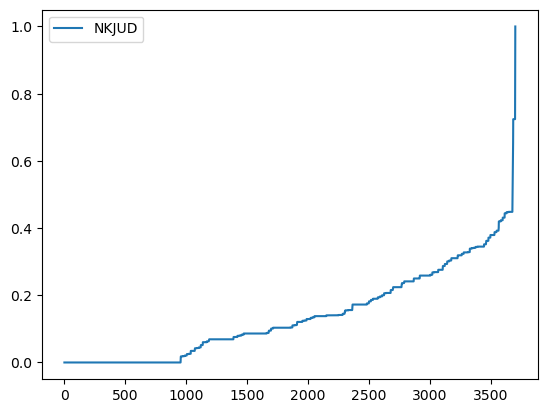

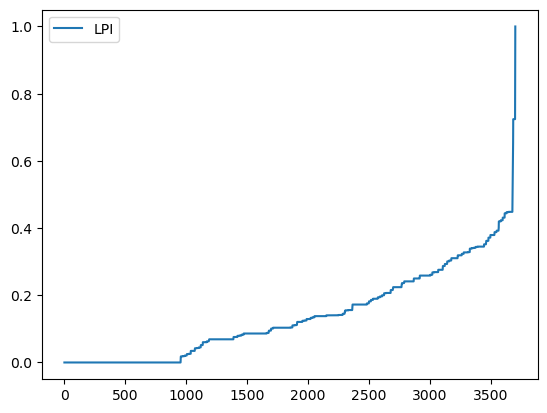

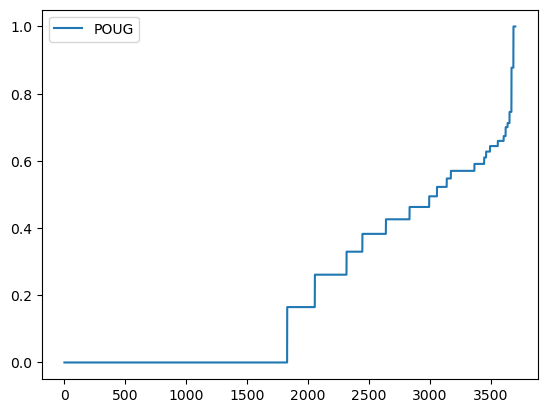

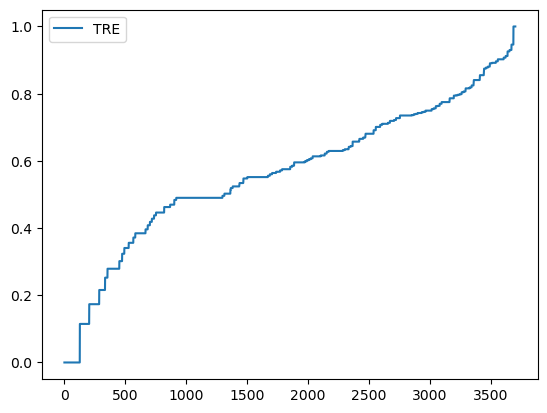

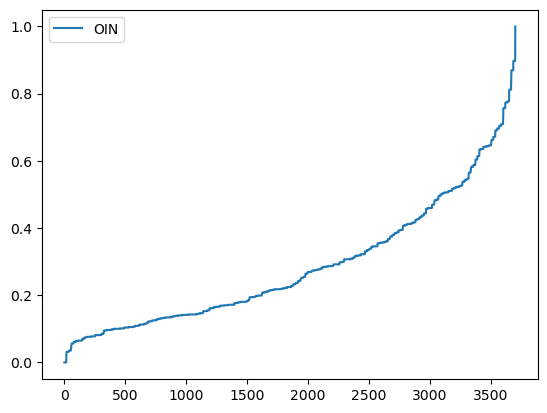

In [10]:
for i in PP.num_vars[1:]:
    df=PP.df_one_hot_encoded[i].sort_values()
    df = df.reset_index()
    del df['index']
    df.plot()

In [11]:
PP.df_one_hot_encoded.head()

,ID,UKL,CDx,NKJUD,LPI,POUG,TRE,Type,OIN,GJAH_ii,...,BJKG_qqqq,BJKG_yy,ZUB_f,ZUB_t,VOL_f,VOL_t,UIO_uuuu,UIO_wwww,VBNM_f,VBNM_t
39,39.0,0.865169,0.155630,0.086207,0.086207,0.261282,0.215727,y,0.104060,0,...,0,0,1,0,0,1,1,0,0,1
40,40.0,0.893258,0.809665,0.379310,0.379310,0.000000,0.000000,y,0.279398,0,...,1,0,1,0,1,0,1,0,1,0
41,41.0,0.707865,0.671701,0.000000,0.000000,0.570290,0.744912,y,0.228120,0,...,0,0,0,1,0,1,0,1,0,1
42,42.0,0.707865,0.668485,0.000000,0.000000,0.627646,0.749549,y,0.587669,0,...,0,0,0,1,0,1,0,1,1,0
43,43.0,0.095506,0.679692,0.189655,0.189655,0.382772,0.601884,y,0.104060,0,...,0,0,0,1,0,1,1,0,1,0


In [12]:
PP.num_vars

['ID', 'UKL', 'CDx', 'NKJUD', 'LPI', 'POUG', 'TRE', 'OIN']

In [13]:
correlation_features = list(PP.num_vars[1:])
correlation_features = list(PP.df_one_hot_encoded.columns)
PP.df_one_hot_encoded['Type'] = PP.df_one_hot_encoded.Type.replace(to_replace=['n', 'y'], value=[0, 1])

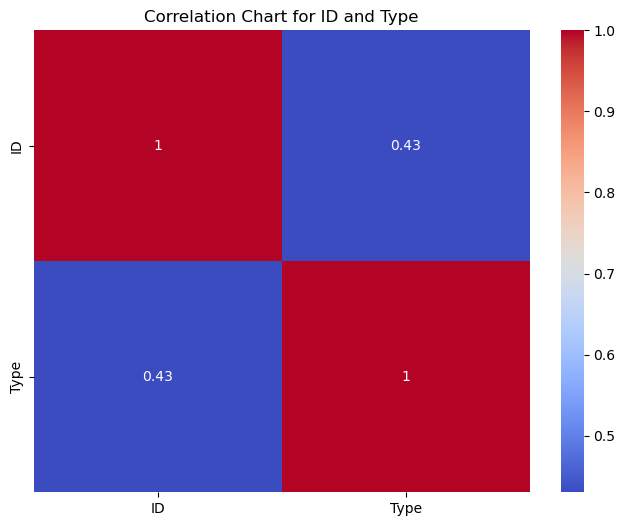

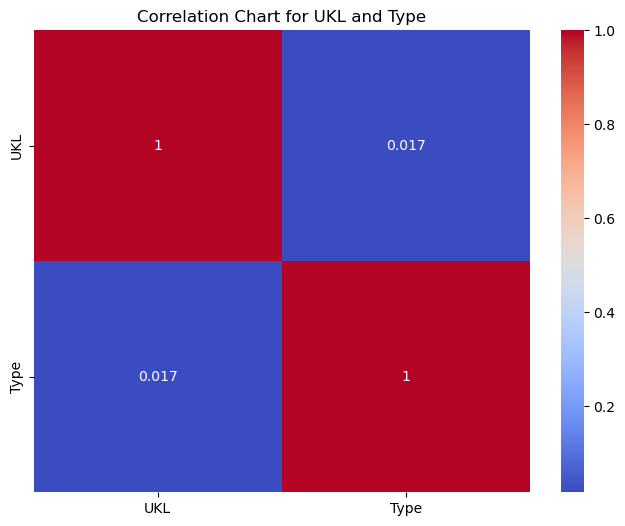

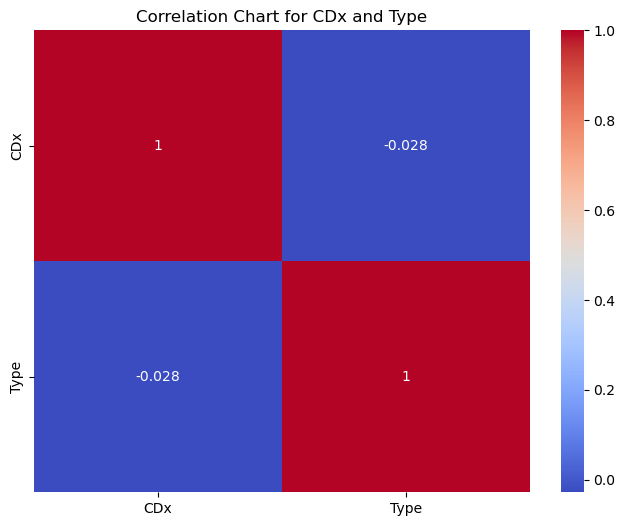

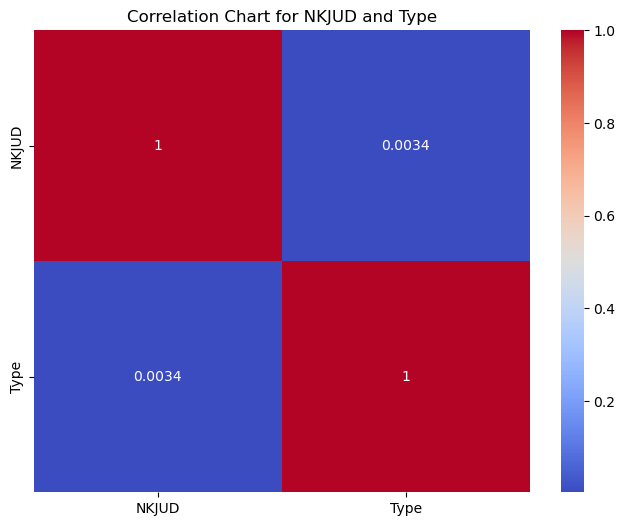

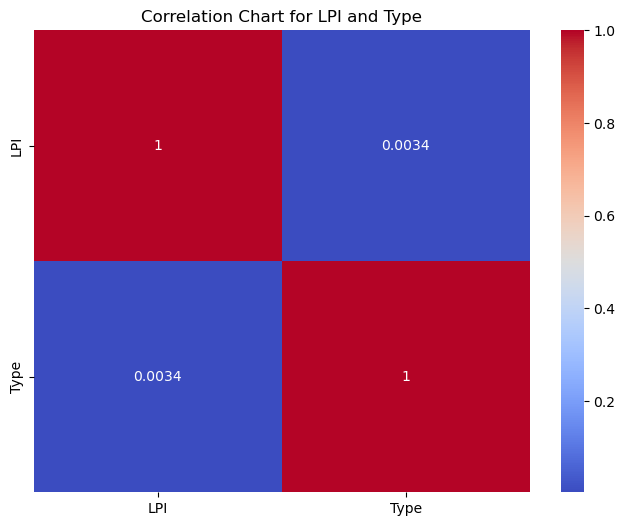

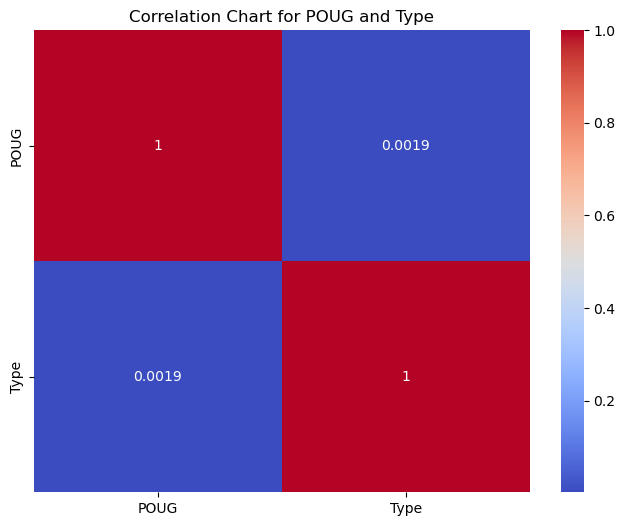

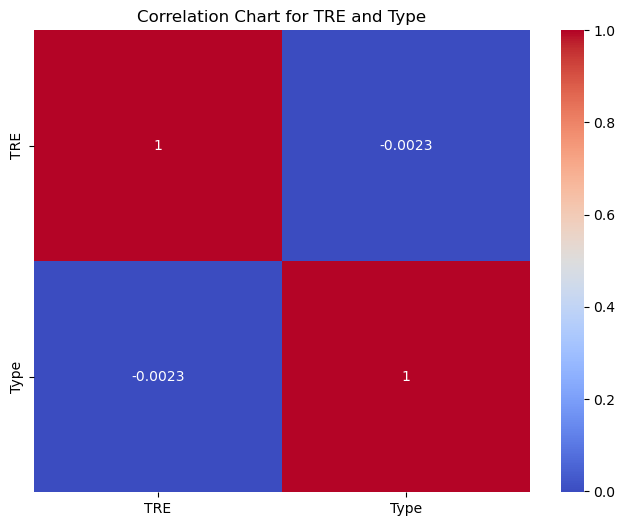

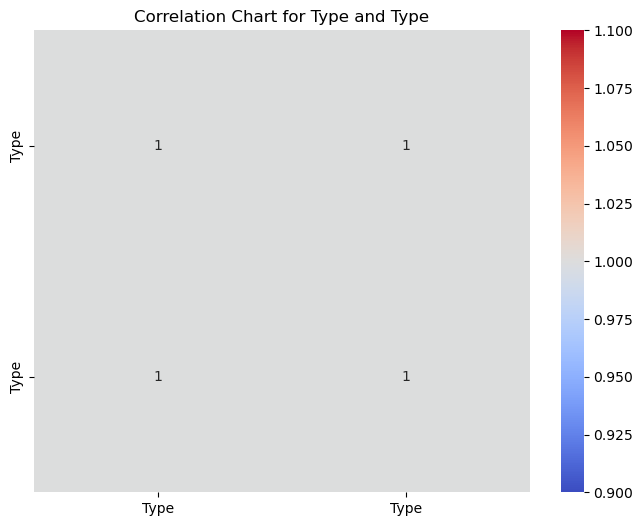

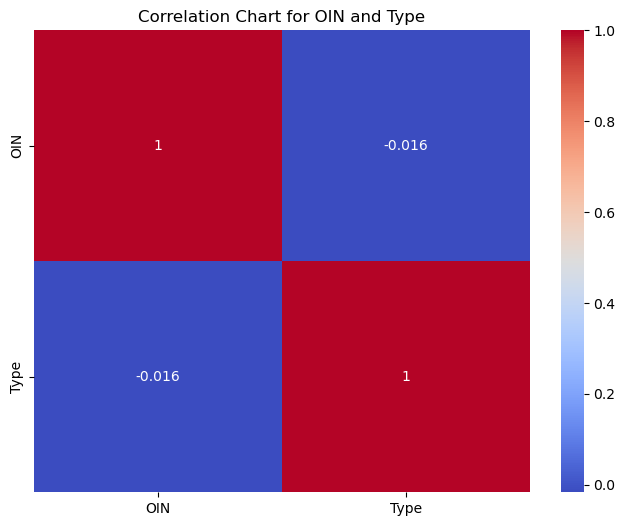

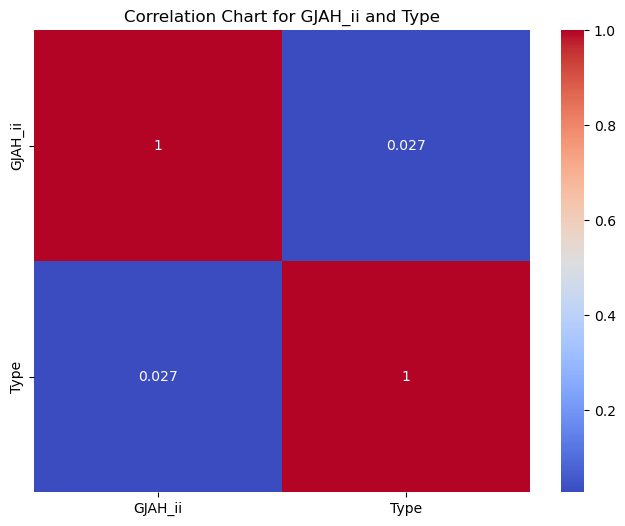

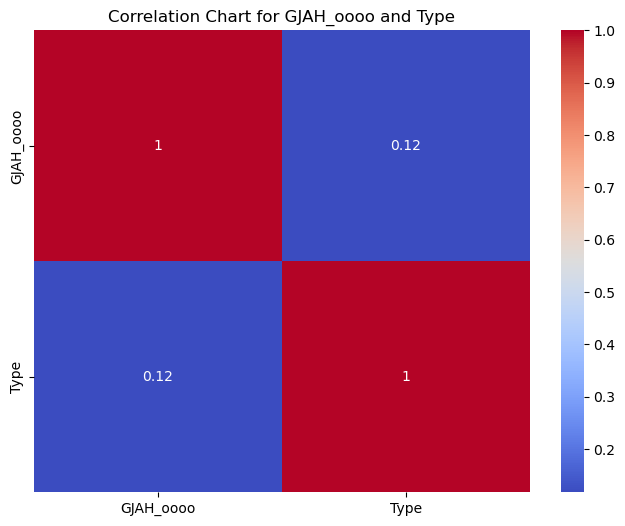

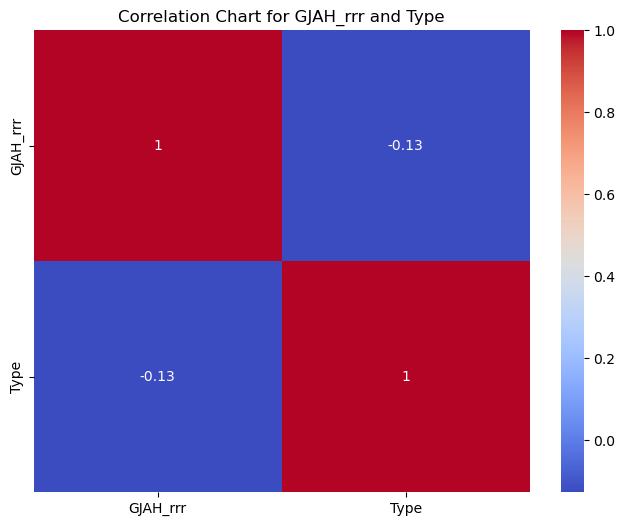

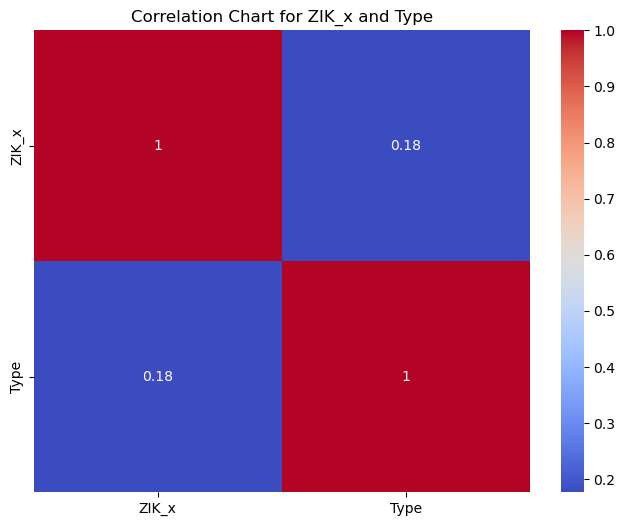

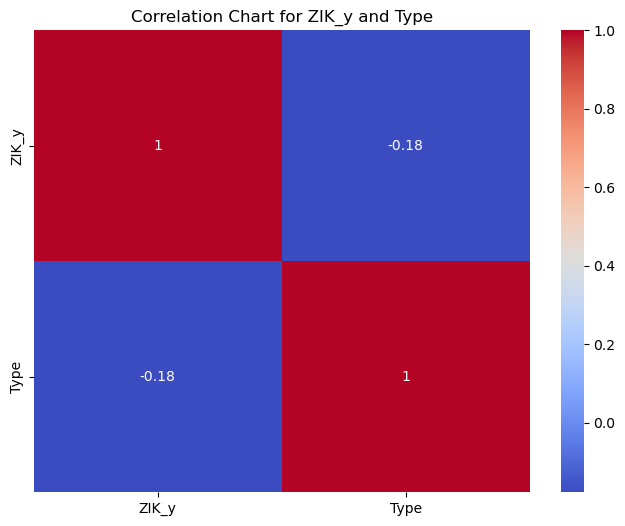

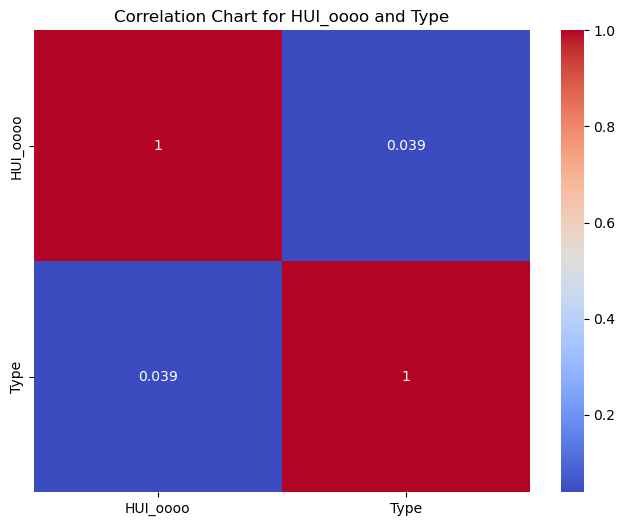

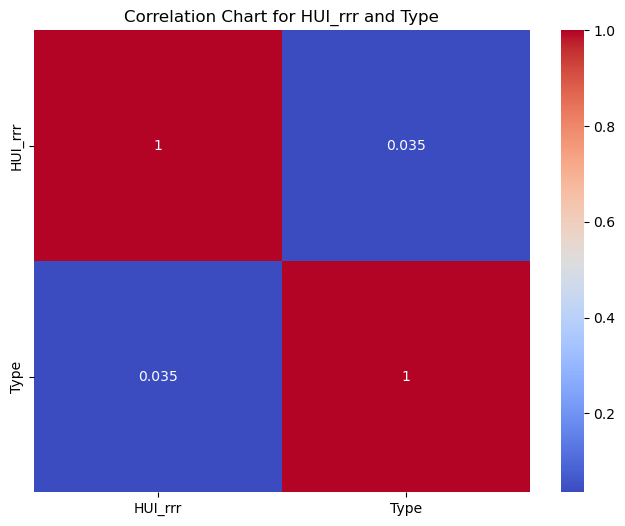

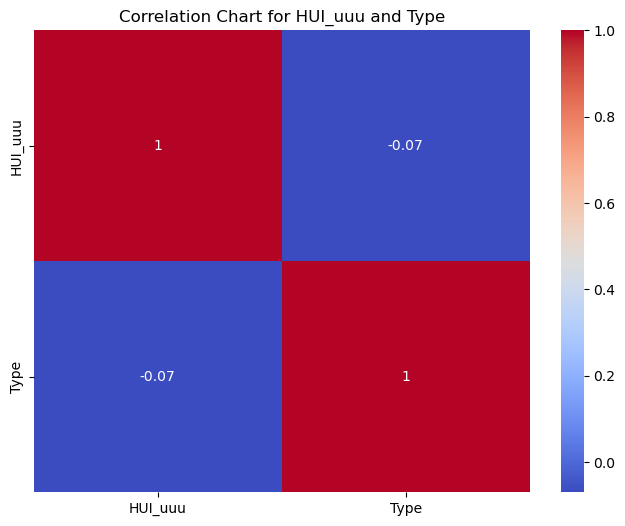

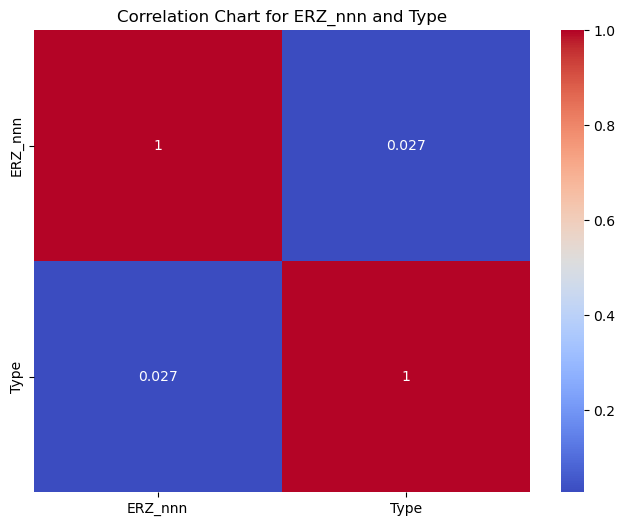

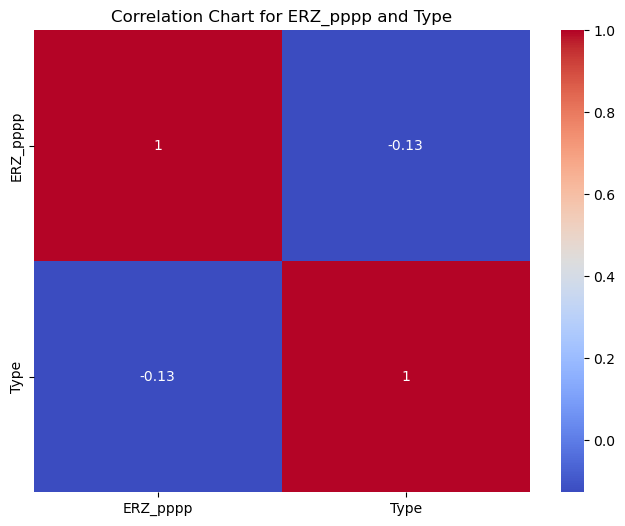

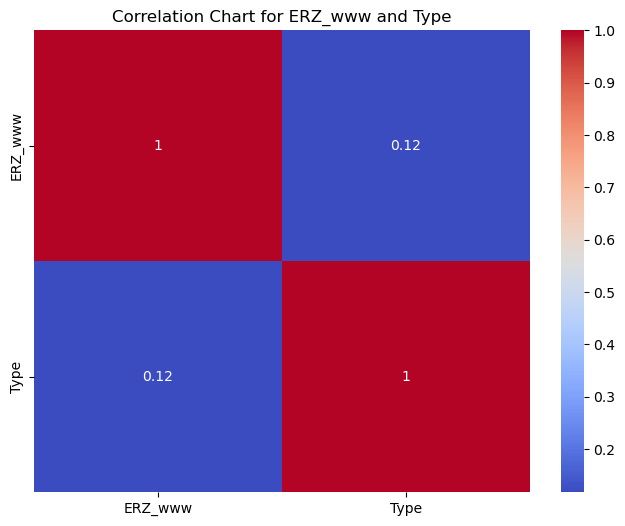

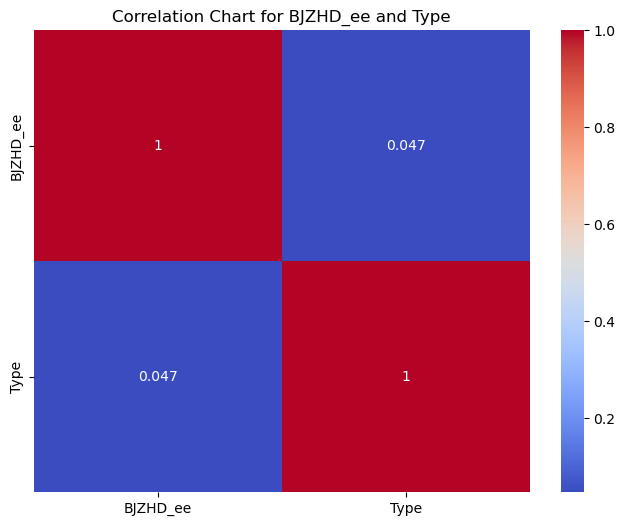

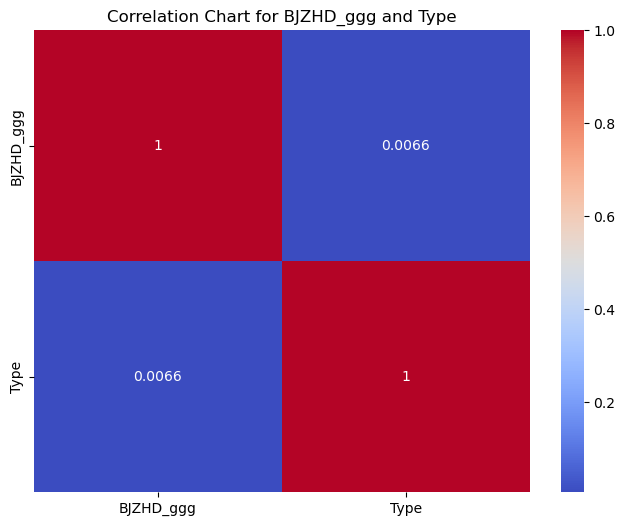

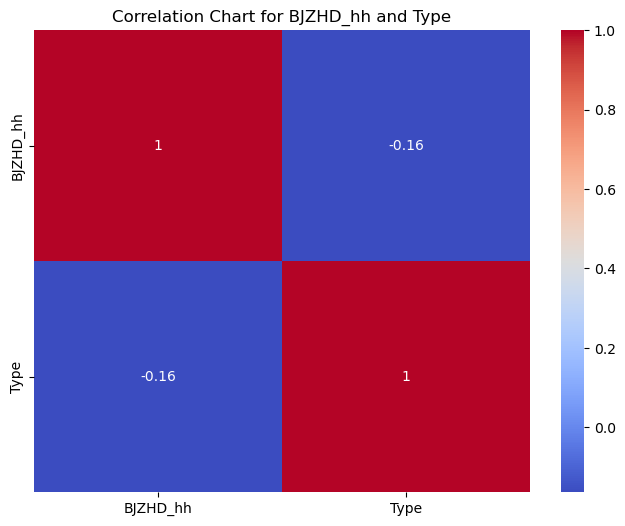

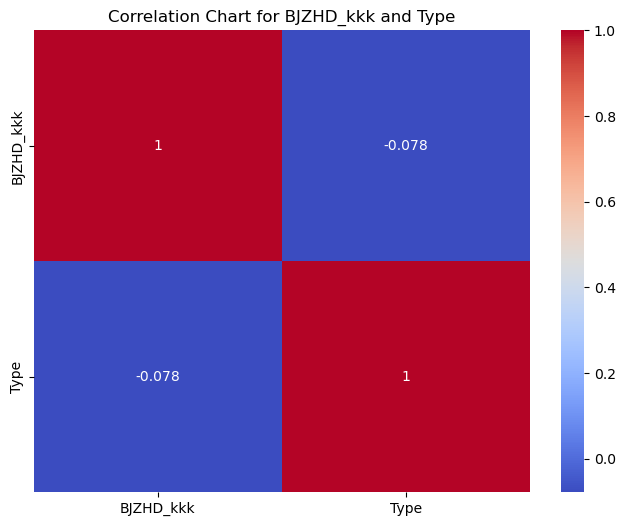

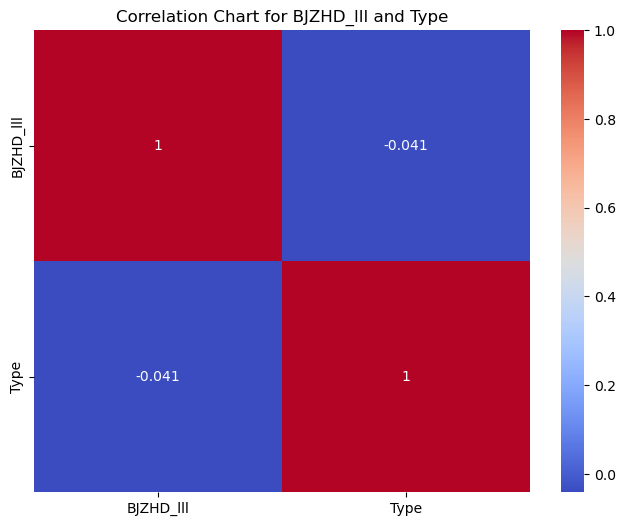

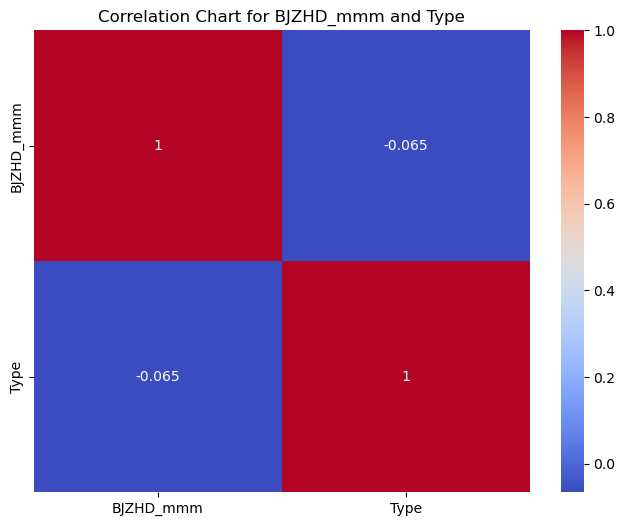

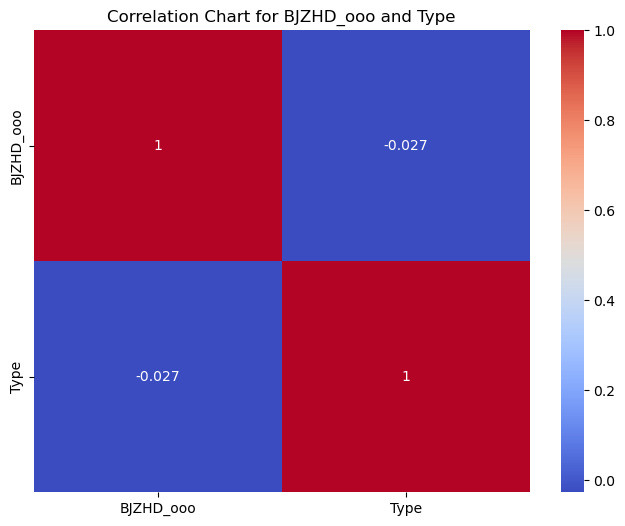

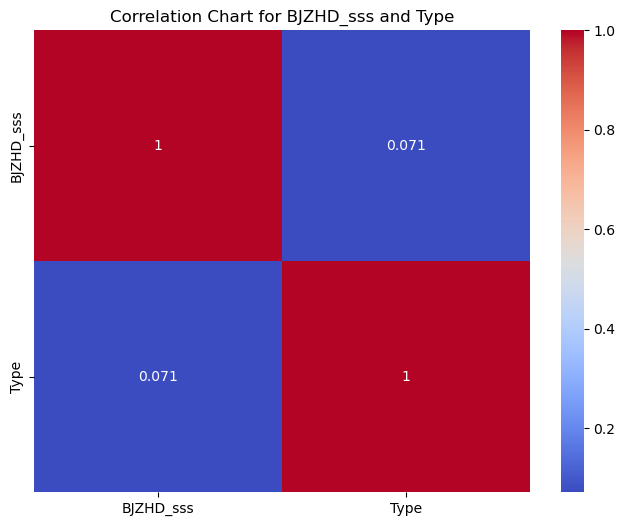

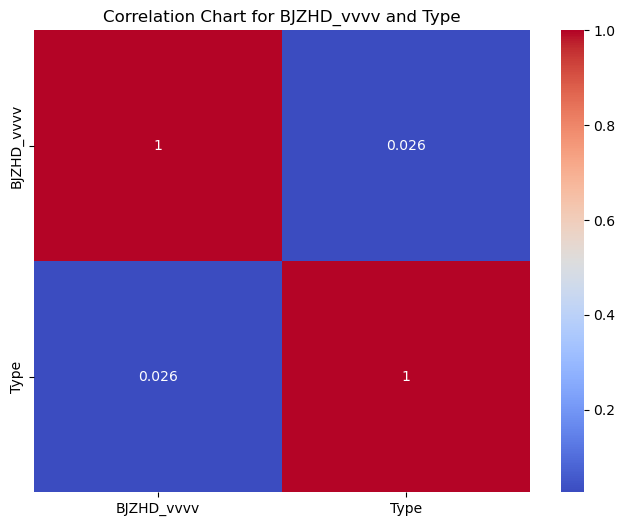

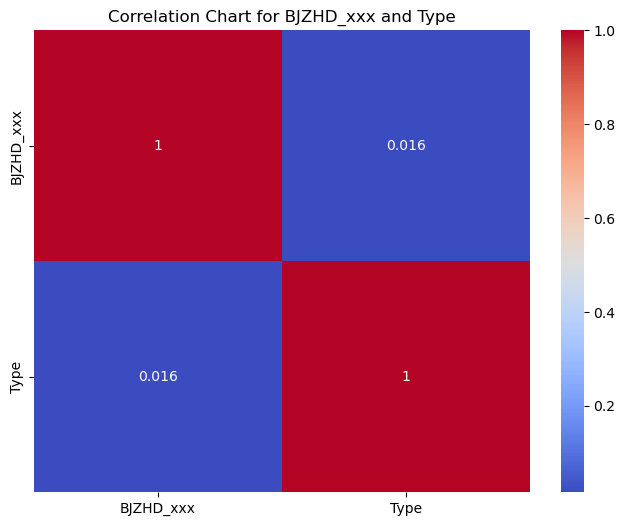

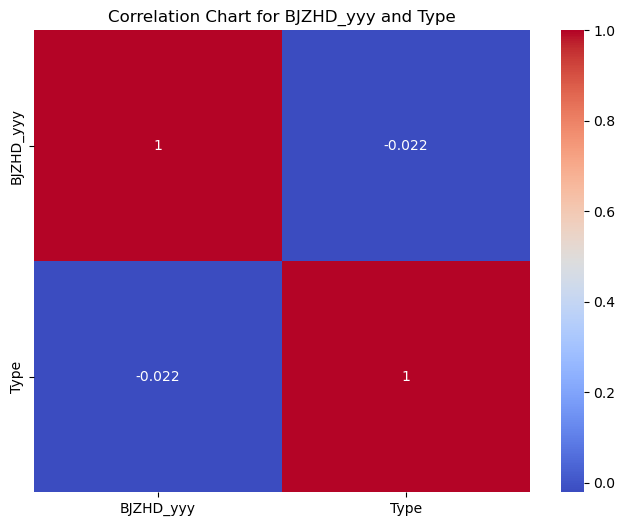

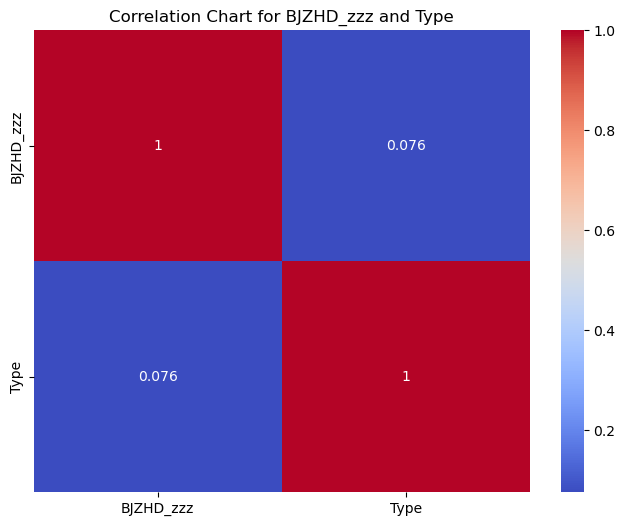

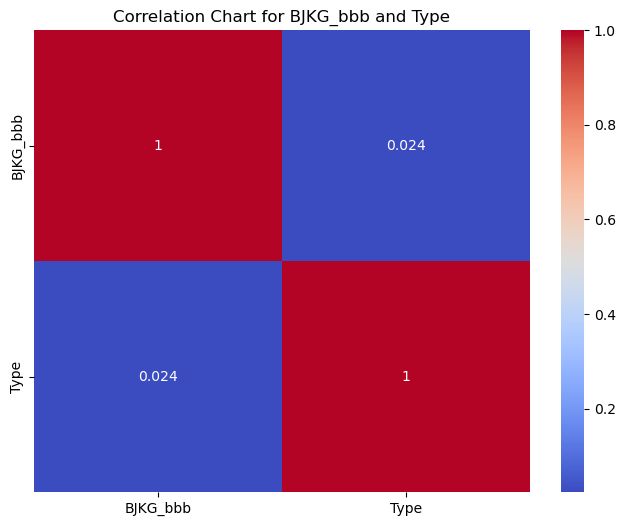

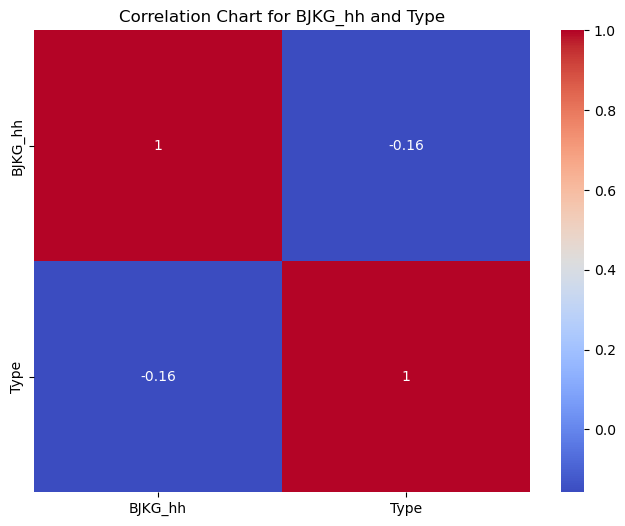

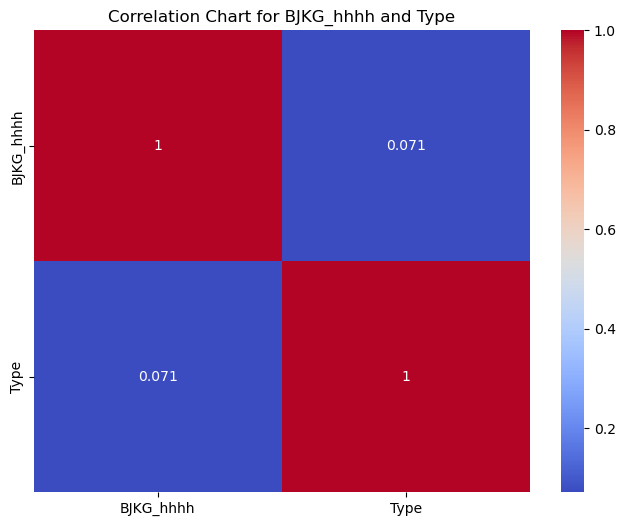

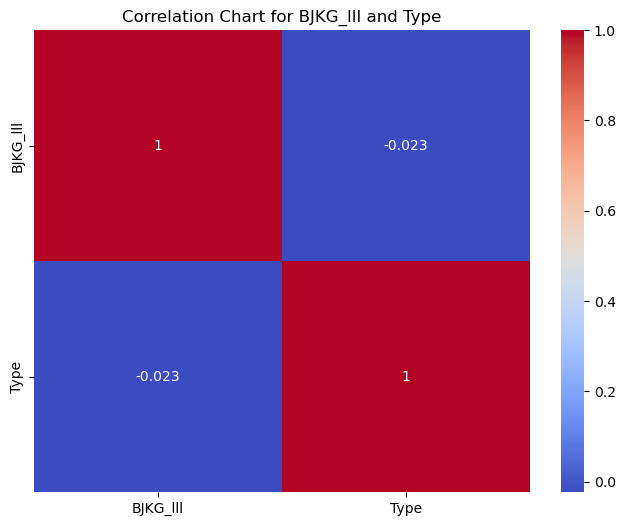

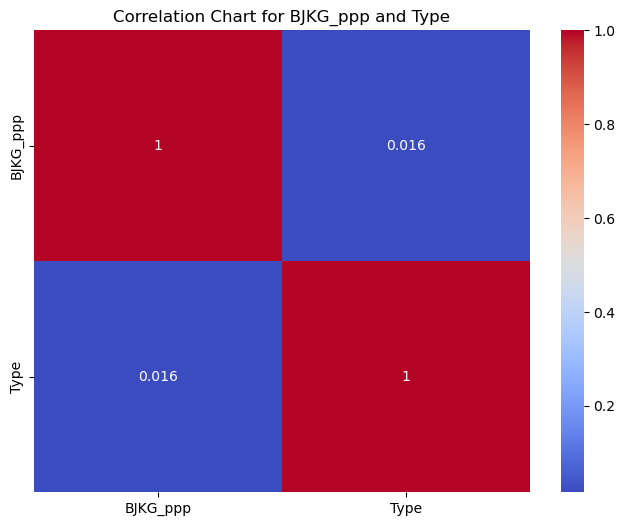

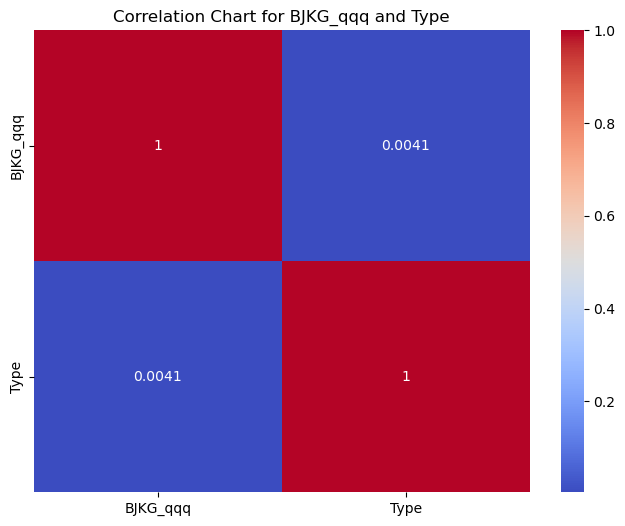

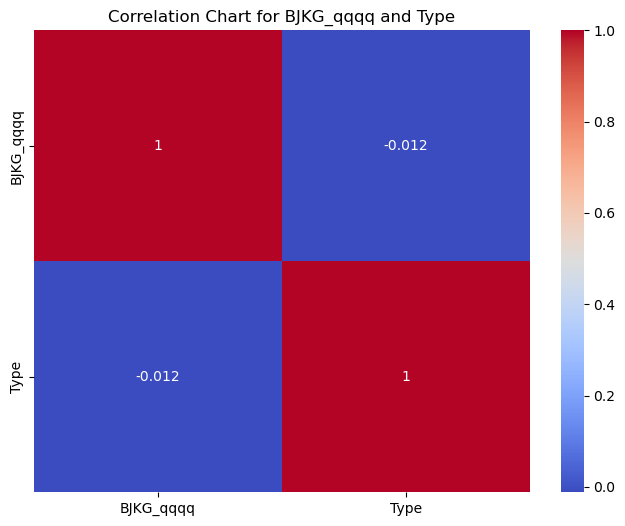

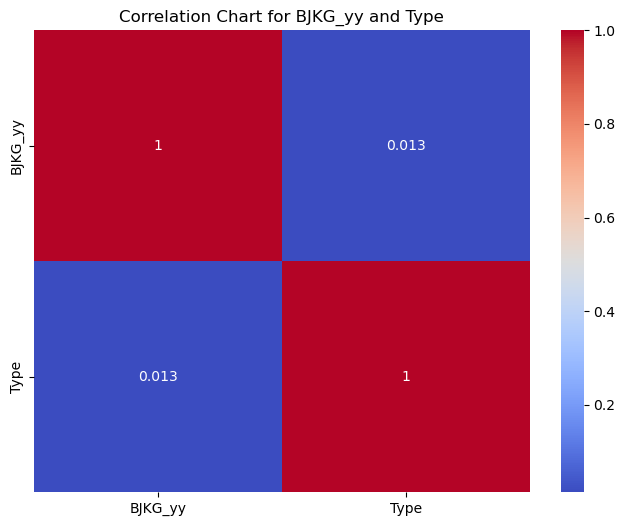

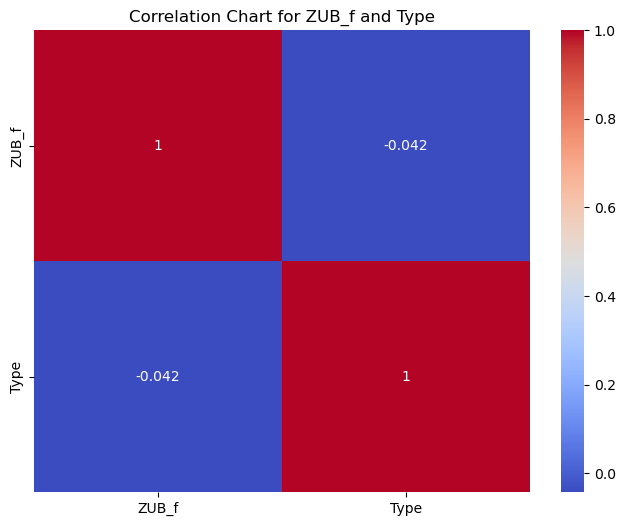

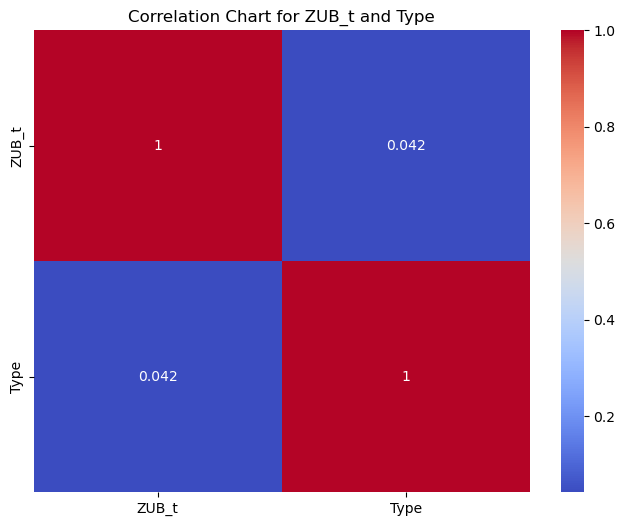

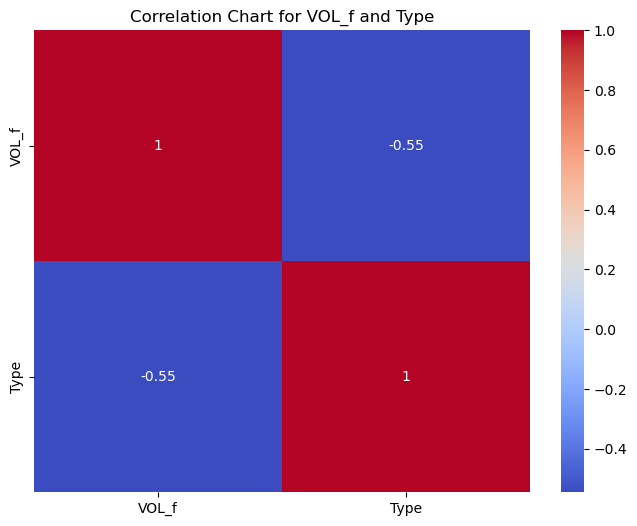

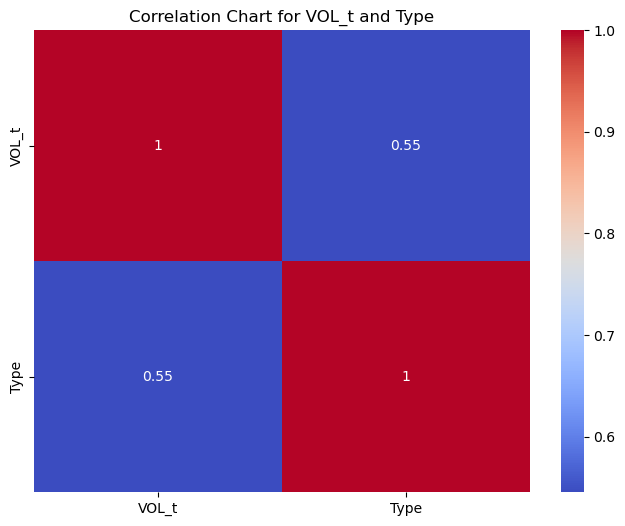

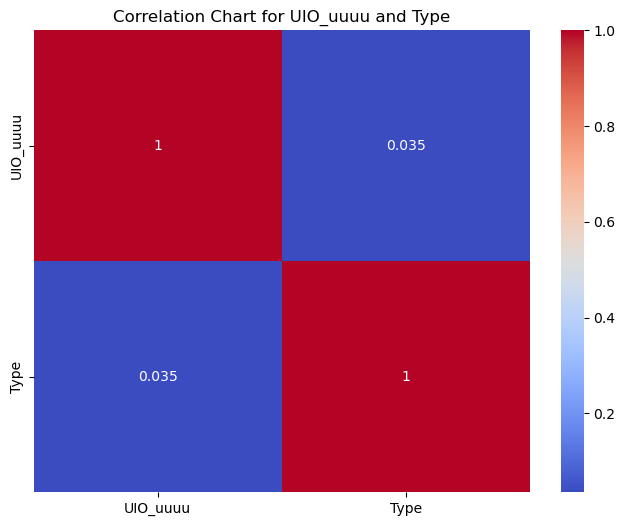

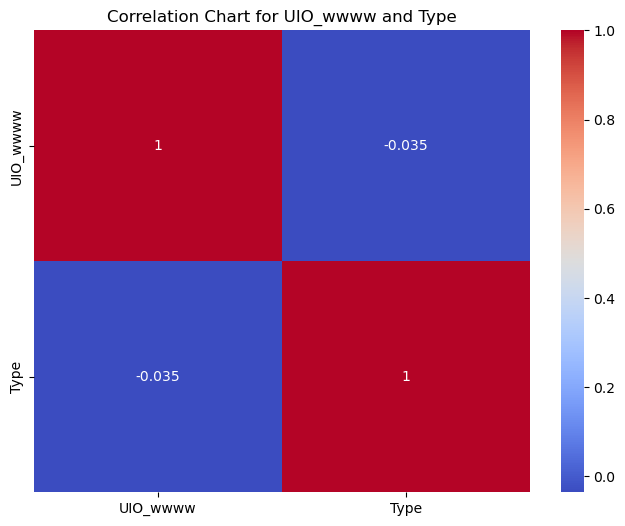

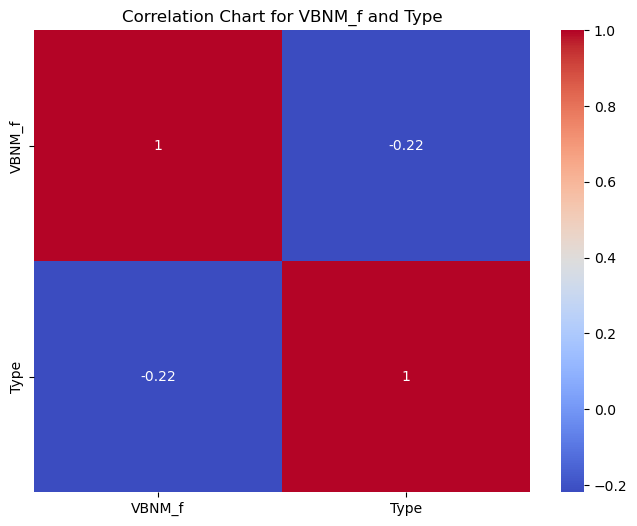

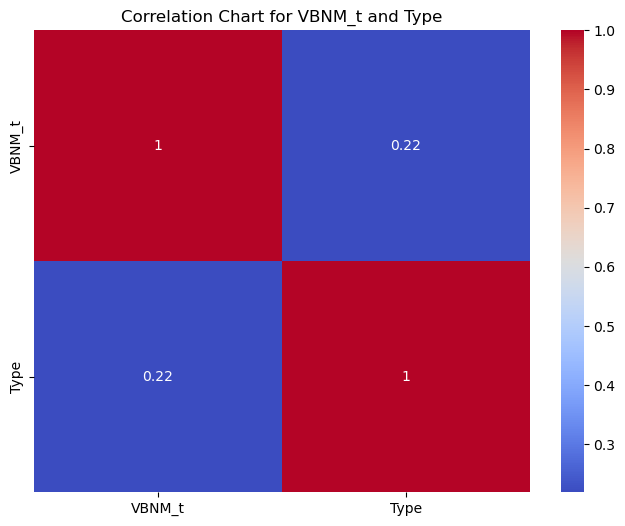

In [14]:
for feature in correlation_features:
    plt.figure(figsize=(8, 6))
    sns.heatmap(PP.df_one_hot_encoded[[feature, 'Type']].corr(), annot=True, cmap='coolwarm')
    plt.title(f'Correlation Chart for {feature} and Type')
    plt.show()

In [15]:
corr_matrix = PP.df_corr.iloc[:,:-2].corr()

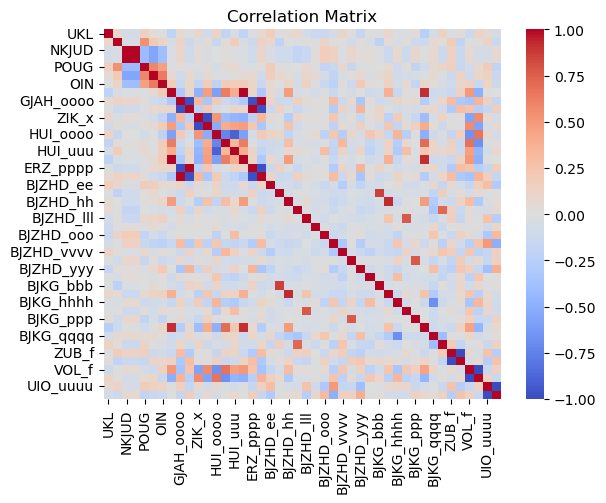

In [16]:
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [17]:
corr_matrix = PP.df_uncorr.iloc[:,:-2].corr()

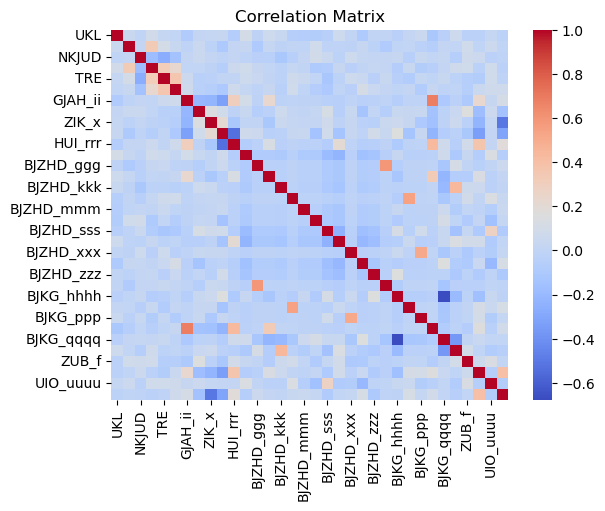

In [18]:
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [19]:
PP.X.shape

(3700, 34)

In [20]:
PP.feature_imp.shape

(34,)

In [21]:
df_all = PP.X
df_all.head()

,UKL,CDx,NKJUD,POUG,TRE,OIN,GJAH_ii,GJAH_oooo,ZIK_x,HUI_oooo,...,BJKG_hhhh,BJKG_lll,BJKG_ppp,BJKG_qqq,BJKG_qqqq,BJKG_yy,ZUB_f,VOL_f,UIO_uuuu,VBNM_f
39,0.865169,0.155630,0.086207,0.261282,0.215727,0.104060,0,1,1,1,...,1,0,0,0,0,0,1,0,1,0
40,0.893258,0.809665,0.379310,0.000000,0.000000,0.279398,0,1,1,1,...,0,0,0,0,1,0,1,1,1,1
41,0.707865,0.671701,0.000000,0.570290,0.744912,0.228120,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0
42,0.707865,0.668485,0.000000,0.627646,0.749549,0.587669,0,1,1,1,...,1,0,0,0,0,0,0,0,0,1
43,0.095506,0.679692,0.189655,0.382772,0.601884,0.104060,0,1,0,1,...,1,0,0,0,0,0,0,0,1,1


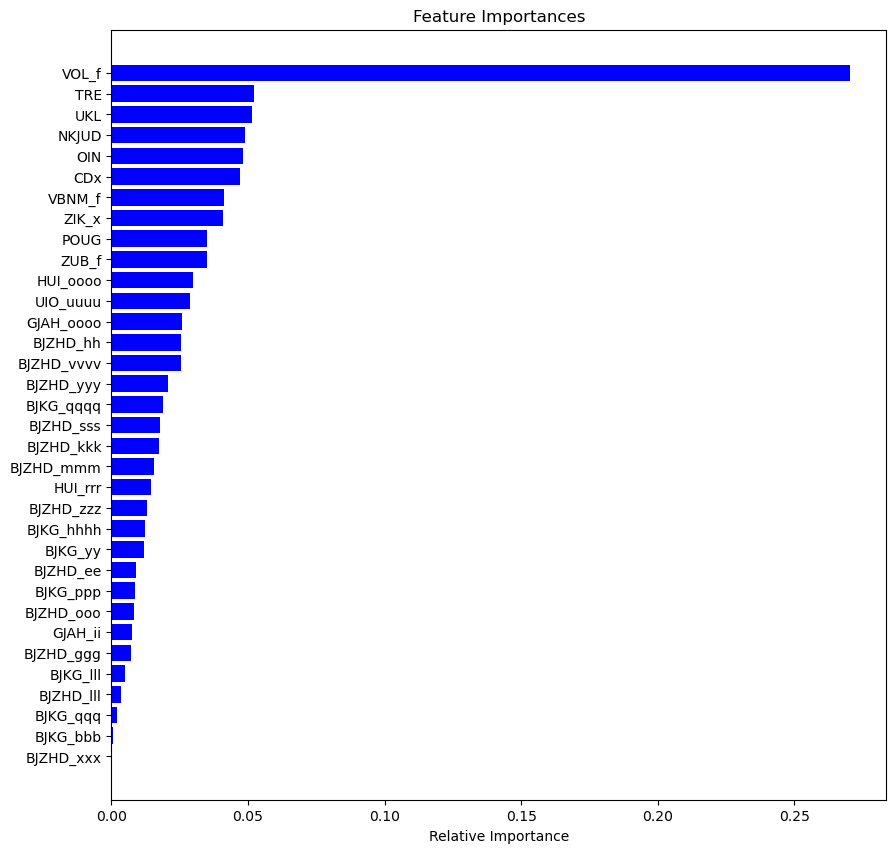

In [22]:
features = df_all.columns
importances = PP.feature_imp
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [23]:
PP.X_new.shape

(3700, 29)

In [24]:
from sklearn.decomposition import PCA
x_reduced = PCA(n_components=2, random_state=0).fit_transform(df_independent_feature)
df = pd.DataFrame(x_reduced)
df["label"] = df_label["Type"]

<Axes: xlabel='0', ylabel='1'>

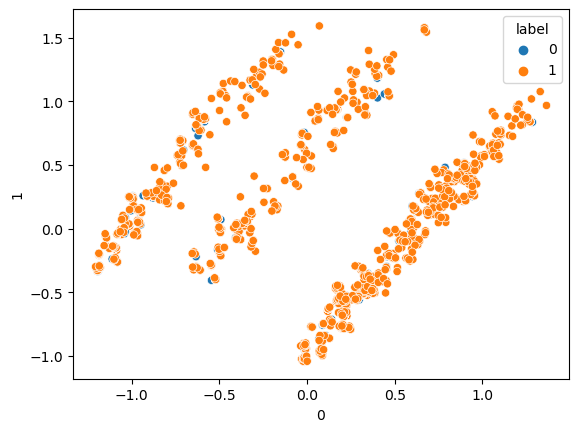

In [25]:
sns.scatterplot(data=df, x=0, y=1, hue="label")


In [26]:
class Model_Selection:
    def __init__(self, df_independent_feature, df_label):
        """
        Take the two input df_independent_features and df_label. 
        """
        self.df_independent_feature = df_independent_feature
        self.df_label = df_label
        pass
    
    def outlier_detection_ocsvm(self):
        """
        Reduce the independent features to two dimensions.
        Perform one class SVM, detect the outliers and remove the outliers        
        """
        self.x_reduced = TSNE(n_components=2, random_state=0).fit_transform(self.df_independent_feature)
        svm = OneClassSVM( nu=0.005, gamma=1e-04)
        svm.fit(self.x_reduced)
        self.x_predicted = svm.predict(self.x_reduced)
        self.df_independent_no_out=self.df_independent_feature[self.x_predicted==1]
        self.df_label_no_out=self.df_label[self.x_predicted==1]  
        
    def grid_search(self):
        """
        Split the independent features and label to train and test set.
        Consider Logistic regression, Random Forest and SVM model for binary classificatio.
        Perform 5 fold cross validation and grid search to find the best model 
        and the corresponding hyperparameters
        """
        
        X_train, X_test, y_train, y_test = train_test_split(self.df_independent_no_out, self.df_label_no_out, test_size=0.2, random_state=42)
        logreg_param_grid = {'C': [0.1, 1, 10],'class_weight': [ 'balanced']}
        rf_param_grid = {'min_samples_split': [10, 20, 30],'n_estimators': [ 100, 200], 'max_depth': [ 4, 5, 6, 7],'class_weight': [ 'balanced']}
        svm_param_grid = {'probability':[True],'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'],'class_weight': [ 'balanced']}
        logreg = LogisticRegression()
        rf = RandomForestClassifier()
        svm = SVC(probability=True)
        gb = GradientBoostingClassifier()
        models = {'Logistic Regression': (logreg, logreg_param_grid),
                  'Random Forest': (rf, rf_param_grid),
                  'SVM': (svm, svm_param_grid)}

        self.model_results = {}
        self.roc_curves = {}
        for model_name, (model, param_grid) in models.items():
            print(f"Performing grid search for {model_name}")
            self.model_results[model_name] = {}

            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
            grid_search.fit(X_train, y_train)

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict_proba(X_test)
            fpr, tpr, thresholds = metrics.roc_curve(y_test['Type'].values, y_pred.T[1], pos_label=1)
            test_accuracy = metrics.auc(fpr, tpr)
            
            
            y_pred_train = best_model.predict_proba(X_train)
            fpr, tpr, thresholds = metrics.roc_curve(y_train['Type'].values, y_pred_train.T[1], pos_label=1)
            train_accuracy = metrics.auc(fpr, tpr)

            self.model_results[model_name]["best_model"] = best_model
            self.model_results[model_name]["params"] = grid_search.best_params_
            self.model_results[model_name]["test_accuracy"] = test_accuracy
            self.model_results[model_name]["train_accuracy"] = train_accuracy
            self.model_results[model_name]["train_accuracy"] = pd.DataFrame(grid_search.cv_results_)   
            self.roc_curves[model_name] = {'fpr': fpr, 'tpr': tpr}
    
    def best_model_score(self):
        """
        Consider the best model after the grid search and calculate evaluation metrics.
        - accuracy
        - precision
        -recall
        - F1
        - ROC curve
        Find the threshold value
        
        Perform thresholding and calculate the evaluation metrics.
        
        """
        X_train, X_test, y_train, y_test = train_test_split(self.df_independent_no_out, self.df_label_no_out, test_size=0.2, random_state=42)
        
        best_model = self.model_results['Random Forest']['best_model']
        
        
        best_model.fit(X_train, y_train)

        self.y_true =y_test.copy()
        y_pred = best_model.predict(X_test)
        y_pred_tr = best_model.predict(X_train)
        
        
        self.cm_train = confusion_matrix(y_train, y_pred_tr)
        self.cm_test = confusion_matrix(y_test, y_pred)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        
        out_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        values = [accuracy, precision, recall, f1]

        self.metrics_df = pd.DataFrame({'Metrics': out_metrics, 'Values': values})
        
        y_pred = best_model.predict_proba(X_test)
        self.y_pred_prob =y_pred.copy()
        self.fpr_ts, self.tpr_ts, thresholds = metrics.roc_curve(y_test['Type'].values, y_pred.T[1], pos_label=1)
        self.roc_auc_test = metrics.auc(self.fpr_ts, self.tpr_ts)
        
        self.metrics_df.loc[len(self.metrics_df)] = ['AUC', self.roc_auc_test]
        
        y_pred_train = best_model.predict_proba(X_train)
        self.fpr_tr, self.tpr_tr, thresholds = metrics.roc_curve(y_train['Type'].values, y_pred_train.T[1], pos_label=1)
        self.roc_auc_train = metrics.auc(self.fpr_tr, self.tpr_tr)
        
    def thresholding(self):
        """
        Find the threshold value from the evaluation metrics scores
        """
        thresholds = []
        f1_scores = []
        precision_scores = []
        recall_scores = []
        y_true = self.y_true
        y_pred_prob = self.y_pred_prob.T[1]
        for threshold in np.arange(0.1, 0.5, 0.01):
            y_pred = (y_pred_prob >= threshold)*1
            
            f1 = f1_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)

            thresholds.append(threshold)
            f1_scores.append(f1)
            precision_scores.append(precision)
            recall_scores.append(recall)
            self.threshold_df = pd.DataFrame({'Threshold': thresholds, 'F1': f1_scores, 'Precison': precision_scores, 'Recall': recall_scores})
    def perform_threshold(self):
        """
        Perform thresholding and find the new evaluation metric scores
        """
        threshold = 0.4  
        y_pred = (self.y_pred_prob.T[1] >= threshold)*1 #astype(int)
        y_true = self.y_true
        
        metrics = {
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'F1 Score': f1_score(y_true, y_pred),
            'Accuracy': accuracy_score(y_true, y_pred)
        }

        
        self.thresholded_metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Score'])
        
        
        pass
    
    def process(self):
        self.outlier_detection_ocsvm()
        self.grid_search()
        self.best_model_score()
        self.thresholding()
        self.perform_threshold()
        
        
        

In [27]:
MS = Model_Selection(df_independent_feature, df_label)
MS.process()

Performing grid search for Logistic Regression
Performing grid search for Random Forest
Performing grid search for SVM


<Axes: xlabel='Threshold'>

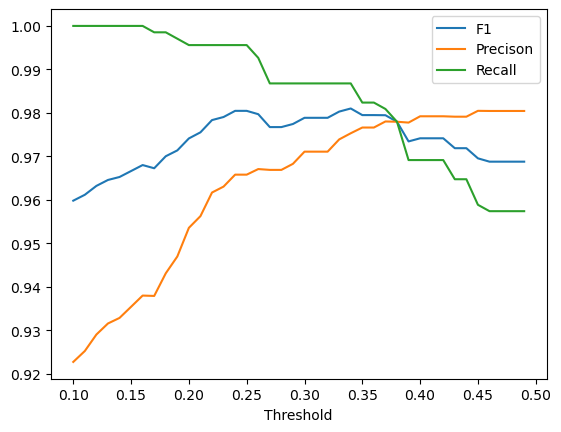

In [28]:
MS.threshold_df.plot(x="Threshold")

In [29]:
MS.model_results

{'Logistic Regression': {'best_model': LogisticRegression(C=0.1, class_weight='balanced'),
  'params': {'C': 0.1, 'class_weight': 'balanced'},
  'test_accuracy': 0.911430558775794,
  'train_accuracy':    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C   
  0       0.017045      0.001233         0.009423        0.000276     0.1  \
  1       0.032856      0.010179         0.010389        0.001218       1   
  2       0.041677      0.004841         0.010688        0.001162      10   
  
    param_class_weight                                  params   
  0           balanced  {'C': 0.1, 'class_weight': 'balanced'}  \
  1           balanced    {'C': 1, 'class_weight': 'balanced'}   
  2           balanced   {'C': 10, 'class_weight': 'balanced'}   
  
     split0_test_score  split1_test_score  split2_test_score  split3_test_score   
  0           0.928322           0.909799           0.933775           0.925325  \
  1           0.928530           0.907509           0.934

In [30]:
df = pd.DataFrame(MS.x_reduced)
df["label"] = df_label["Type"]

<Axes: xlabel='0', ylabel='1'>

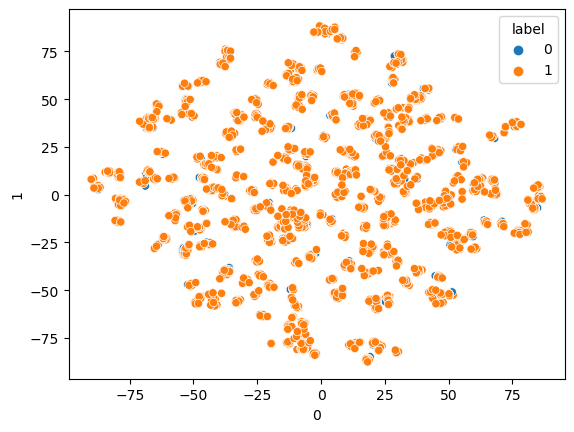

In [31]:
sns.scatterplot(data=df, x=0, y=1, hue="label")

In [32]:
MS.metrics_df

,Metrics,Values
0,Accuracy,0.943089
1,Precision,0.980451
2,Recall,0.957416
3,F1 Score,0.968796
4,AUC,0.955071


In [33]:
MS.cm_train

array([[ 190,   29],
       [ 124, 2606]])

In [34]:
MS.cm_test

array([[ 44,  13],
       [ 29, 652]])

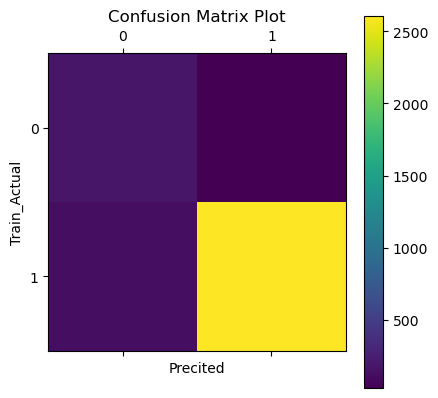

In [35]:
plt.matshow(MS.cm_train)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Precited')
plt.ylabel('Train_Actual')
plt.show();

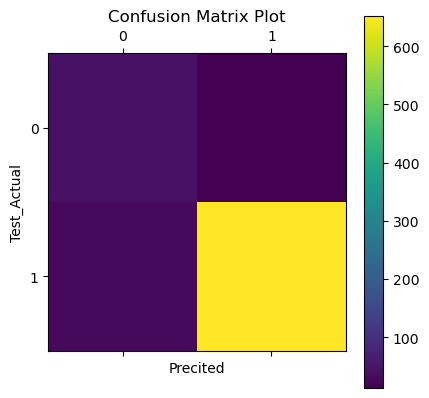

In [36]:
plt.matshow(MS.cm_test)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Precited')
plt.ylabel('Test_Actual')
plt.show();

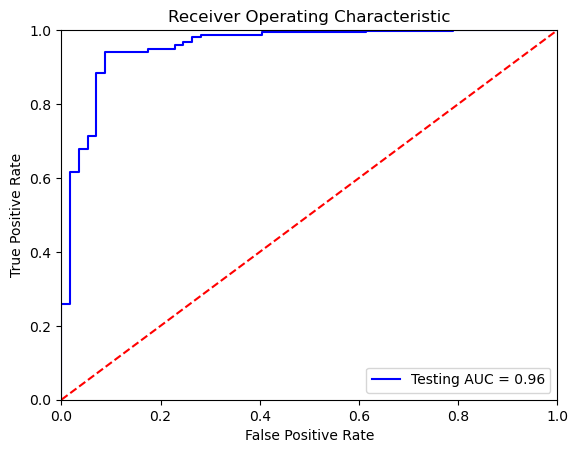

In [37]:
plt.title('Receiver Operating Characteristic')
#plt.plot(MS.fpr_tr, MS.tpr_tr, 'g', label = 'Training AUC = %0.2f' % MS.roc_auc_train)
plt.plot(MS.fpr_ts, MS.tpr_ts, 'b', label = 'Testing AUC = %0.2f' % MS.roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
df = MS.threshold_df      

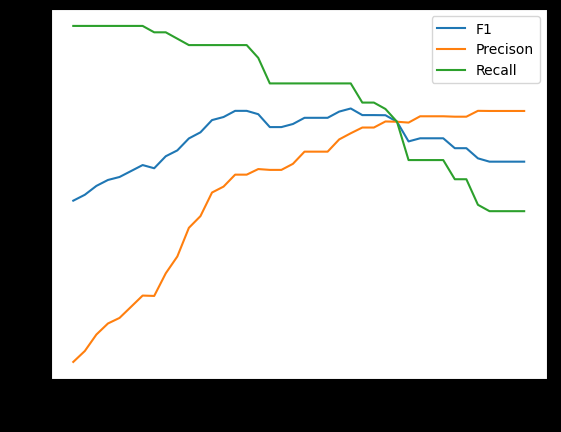

In [40]:
x=df['Threshold']
fig = plt.figure(facecolor='black')
for column in df.columns[1:]:
    y = df[column]
    plt.plot(x, y, label=column)
plt.xlabel('Threshold')
plt.legend()
plt.show()


In [41]:
MS.thresholded_metrics_df


,Score
Precision,0.979228
Recall,0.969163
F1 Score,0.974170
Accuracy,0.952575


threshold = 0.4

idx = np.where(thresholds >= threshold)[0][0]

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1],'r--')
plt.scatter(fpr[idx], tpr[idx], c='red', label=f'Threshold = {threshold}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()
   